## **Importando as dependências, OS e iniciando SparkSession**

In [1]:
# instalando as dependências
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz
!tar xf spark-3.1.2-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Iniciando com Spark") \
    .config('spark.ui.port', '4050') \
    .getOrCreate()

In [5]:
spark

In [6]:
!wget -q https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   


In [7]:
get_ipython().system_raw('./ngrok authtoken 2IAzSgOhNxfkxrV1MQEmNqrHBRS_2PDkj8UN4X5gPJWnHXhrq')
get_ipython().system_raw('./ngrok http 4050 &')

In [8]:
!curl -s http://localhost:4040/api/tunnels

{"tunnels":[],"uri":"/api/tunnels"}


In [9]:
# carregando o arquivo

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Carregando e visualizando os dados**

A base base de dados possui 3 campos principais: anuncio, imagens e usuario. Nessa análise, apenas as informações do campo "anuncio" serão relevantes.



In [10]:
dataframe = spark.read.json('/content/drive/MyDrive/Imoveis/dataset_bruto.json')

In [11]:
anuncio = dataframe.select('anuncio.*')
anuncio.show(5)

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    0|        []|     [16]|      [0]|                  []|{Centro, 20061003...|47d553e0-79f2-4a4...|    [0]|   [0]|       Usado|      Outros|  Comercial| [1]|[{260, 107, Venda...|
|    0|        []|     [14]|      [0]|                  []|{Centro, 20051040...|b6ffbae1-17f6-487...|    [0]|    []|       Usado|      Outros|  Comercial| [0]|[{260, 107, Venda...|
|    0|    [1026]|   [1026]|      [0]|                  []|{Maria da Graça, ...|1fb030a5-9e3e-4

## **Filtrando as colunas e convertendo**

Foram realizados alguns filtros nas colunas:

tipo_uso: Residencial;
tipo_unidade: Apartamento;
tipo_anuncio: Usado.

In [12]:
anuncio.where('tipo_uso == "Residencial" and tipo_unidade == "Apartamento" and tipo_anuncio == "Usado"')

DataFrame[andar: bigint, area_total: array<string>, area_util: array<string>, banheiros: array<bigint>, caracteristicas: array<string>, endereco: struct<bairro:string,cep:string,cidade:string,estado:string,latitude:double,longitude:double,pais:string,rua:string,zona:string>, id: string, quartos: array<bigint>, suites: array<bigint>, tipo_anuncio: string, tipo_unidade: string, tipo_uso: string, vaga: array<bigint>, valores: array<struct<condominio:string,iptu:string,tipo:string,valor:string>>]

In [13]:
anuncio = anuncio.filter("tipo_uso == 'Residencial'")
anuncio = anuncio.filter("tipo_unidade == 'Apartamento'")
anuncio = anuncio.filter("tipo_anuncio == 'Usado'")

In [14]:
anuncio.show(10) # conferindo se os filtros foram aplicados

+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|andar|area_total|area_util|banheiros|     caracteristicas|            endereco|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|
+-----+----------+---------+---------+--------------------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+
|    3|      [43]|     [43]|      [1]|[Academia, Churra...|{Paciência, 23585...|d2e3a3aa-09b5-45a...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{245, null, Vend...|
|    2|      [42]|     [42]|      [1]|[Churrasqueira, P...|{Paciência, 23585...|085bab2c-87ad-452...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{0, 0, Venda, 15...|
|    1|      [41]|     [41]|      [1]|[Portaria 24h, Co...|{Guaratiba, 23036...|18d22cbe-1b86-4

## **Extraindo bairros e zonas**

A equipe de ciência de dados nos solicitou que apenas as informações sobre bairro e zona da cidade fossem extraídas. Então, vamos analisar a coluna endereco e transformar apenas as informações sobre bairro e zona em colunas de nosso DataFrame.

In [15]:
endereco = anuncio.select('endereco')
endereco.show(5)

+--------------------+
|            endereco|
+--------------------+
|{Paciência, 23585...|
|{Paciência, 23585...|
|{Guaratiba, 23036...|
|{Cosmos, 23066271...|
|{Guaratiba, 23036...|
+--------------------+
only showing top 5 rows



In [16]:
endereco = endereco.withColumn('bairro', endereco['endereco']['bairro'])
endereco = endereco.withColumn('zona', endereco['endereco']['zona'])

In [17]:
# adicionando colunas bairro e zona ao dataframe:

anuncio = anuncio.withColumn('bairro', anuncio['endereco']['bairro'])
anuncio = anuncio.withColumn('zona', anuncio['endereco']['zona'])
anuncio = anuncio.drop('endereco')
anuncio.show(5)

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+---------+----------+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|             valores|   bairro|      zona|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+--------------------+---------+----------+
|    3|      [43]|     [43]|      [1]|[Academia, Churra...|d2e3a3aa-09b5-45a...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{245, null, Vend...|Paciência|Zona Oeste|
|    2|      [42]|     [42]|      [1]|[Churrasqueira, P...|085bab2c-87ad-452...|    [2]|    []|       Usado| Apartamento|Residencial| [1]|[{0, 0, Venda, 15...|Paciência|Zona Oeste|
|    1|      [41]|     [41]|      [1]|[Portaria 24h, Co...|18d22cbe-1b86-476...|    [2]|    []|

## **Convertendo itens das colunas quartos, suites, banheiros, vaga, area_total e area_util de array para integer**

Como pessoas engenheiras de dados, nós queremos entregar a base de dados de forma mais estruturada para que o time de ciência de dados possa realizar os tratamentos e criação do modelo de machine learning.

Nesse contexto, transforme os dados das colunas "quartos", "suites", "banheiros", "vaga", "area_total" e "area_util" de listas para inteiros.

In [18]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType



In [19]:
# Colunas com dados dentro de listas

listas = ['quartos', 'suites', 'banheiros', 'vaga', 'area_total', 'area_util']

In [20]:
anuncio = anuncio.withColumn('quartos', anuncio['quartos'][0].cast(IntegerType()))

In [21]:
anuncio = anuncio.withColumn('suites', anuncio['suites'][0].cast(IntegerType()))

In [22]:
anuncio = anuncio.withColumn('banheiros', anuncio['banheiros'][0].cast(IntegerType()))

In [23]:
anuncio = anuncio.withColumn('vaga', anuncio['vaga'][0].cast(IntegerType()))

In [24]:
anuncio = anuncio.withColumn('area_total', anuncio['area_total'][0].cast(IntegerType()))

In [25]:
anuncio = anuncio.withColumn('area_util', anuncio['area_util'][0].cast(IntegerType()))

In [26]:
anuncio.printSchema() # conferindo a conversão

root
 |-- andar: long (nullable = true)
 |-- area_total: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- tipo_anuncio: string (nullable = true)
 |-- tipo_unidade: string (nullable = true)
 |-- tipo_uso: string (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- valores: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- condominio: string (nullable = true)
 |    |    |-- iptu: string (nullable = true)
 |    |    |-- tipo: string (nullable = true)
 |    |    |-- valor: string (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)



**Vamos simplificar a compreensão da coluna valores, a mais importante da base. Vamos transformar os dados dessa coluna em colunas separadas.**

In [27]:
valores = anuncio.select('valores')

In [28]:
valores = valores \
    .withColumn('condominio', anuncio['valores']['condominio'][0]) \
    .withColumn('iptu', anuncio['valores']['iptu'][0]) \
    .withColumn('tipo', anuncio['valores']['tipo'][0]) \
    .withColumn('valor', anuncio['valores']['valor'][0])

valores.limit(5).show()

+--------------------+----------+----+-----+-----+
|             valores|condominio|iptu| tipo|valor|
+--------------------+----------+----+-----+-----+
|[{245, null, Vend...|       245|null|Venda|15000|
|[{0, 0, Venda, 15...|         0|   0|Venda|15000|
|[{0, 0, Venda, 20...|         0|   0|Venda|20000|
|[{285, null, Vend...|       285|null|Venda|20000|
|[{245, null, Vend...|       245|null|Venda|15000|
+--------------------+----------+----+-----+-----+



In [29]:
anuncio = anuncio \
    .withColumn('condominio', anuncio['valores']['condominio'][0]) \
    .withColumn('iptu', anuncio['valores']['iptu'][0]) \
    .withColumn('tipo', anuncio['valores']['tipo'][0]) \
    .withColumn('valor', anuncio['valores']['valor'][0])
anuncio = anuncio.drop('valores')
anuncio.limit(5).show()

+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|andar|area_total|area_util|banheiros|     caracteristicas|                  id|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|   bairro|      zona|condominio|iptu| tipo|valor|
+-----+----------+---------+---------+--------------------+--------------------+-------+------+------------+------------+-----------+----+---------+----------+----------+----+-----+-----+
|    3|        43|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|       245|null|Venda|15000|
|    2|        42|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|       Usado| Apartamento|Residencial|   1|Paciência|Zona Oeste|         0|   0|Venda|15000|
|    1|        41|       41|        1|[Portaria 24h, Co...|1

## **Selecionando apenas "Vendas"**

Como se trata de um estudo sobre o preço de venda dos imóveis, iremos usar apenas informações do tipo VENDA.

In [30]:
valores.groupby('tipo').count().show()

+-------+-----+
|   tipo|count|
+-------+-----+
|Aluguel|  214|
|  Venda|66348|
+-------+-----+



In [31]:
valores_venda = valores.filter(valores.tipo == "Venda")
valores_venda.show()

+--------------------+----------+----+-----+-----+
|             valores|condominio|iptu| tipo|valor|
+--------------------+----------+----+-----+-----+
|[{245, null, Vend...|       245|null|Venda|15000|
|[{0, 0, Venda, 15...|         0|   0|Venda|15000|
|[{0, 0, Venda, 20...|         0|   0|Venda|20000|
|[{285, null, Vend...|       285|null|Venda|20000|
|[{245, null, Vend...|       245|null|Venda|15000|
|[{285, null, Vend...|       285|null|Venda|20000|
|[{250, null, Vend...|       250|null|Venda|15000|
|[{245, null, Vend...|       245|null|Venda|15000|
|[{245, null, Vend...|       245|null|Venda|15000|
|[{240, null, Vend...|       240|null|Venda|17999|
|[{0, 0, Venda, 15...|         0|   0|Venda|15000|
|[{240, 0, Venda, ...|       240|   0|Venda|19999|
|[{245, null, Vend...|       245|null|Venda|19999|
|[{290, null, Vend...|       290|null|Venda|25000|
|[{285, null, Vend...|       285|null|Venda|29999|
|[{0, 0, Venda, 30...|         0|   0|Venda|30000|
|[{null, null, Ven...|      nul

In [32]:
anuncio = anuncio.where(anuncio.tipo == 'Venda')

## **Salvando os dados tratados como Parquet**

In [33]:
anuncio.write.parquet(
    path='/content/drive/MyDrive/Imoveis/PARQUET',
    mode='overwrite'
)

In [34]:
anuncio_parquet = spark.read.parquet(
    '/content/drive/MyDrive/Imoveis/PARQUET'
)

## **Selecionando os features**

In [35]:
# algumas colunas possuem um único valor, então podem ser removidas

anuncio = anuncio.drop('tipo_anuncio')
anuncio = anuncio.drop('tipo_unidade')
anuncio = anuncio.drop('tipo_uso')

In [36]:
dados_sem_caracteristicas = anuncio.drop('caracteristicas') # somente para facilitar a contade de valores nulos abaixo

In [37]:
# área total e área útil tem muitos valores iguais, verifiquei qual tem mais valores nulos e retirei

dados_sem_caracteristicas\
   .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados_sem_caracteristicas.columns])\
    .show()


+-----+----------+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+
|andar|area_total|area_util|banheiros| id|quartos|suites|vaga|bairro|zona|condominio|iptu|tipo|valor|
+-----+----------+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+
|    0|      9186|        0|        0|  0|      0|  5544|3008|     0|   0|      2347|7155|   0|    0|
+-----+----------+---------+---------+---+-------+------+----+------+----+----------+----+----+-----+



In [38]:
anuncio = anuncio.drop('area_total')

In [39]:
anuncio.show(10)

+-----+---------+---------+--------------------+--------------------+-------+------+----+---------+----------+----------+----+-----+-----+
|andar|area_util|banheiros|     caracteristicas|                  id|quartos|suites|vaga|   bairro|      zona|condominio|iptu| tipo|valor|
+-----+---------+---------+--------------------+--------------------+-------+------+----+---------+----------+----------+----+-----+-----+
|    3|       43|        1|[Academia, Churra...|d2e3a3aa-09b5-45a...|      2|  null|   1|Paciência|Zona Oeste|       245|null|Venda|15000|
|    2|       42|        1|[Churrasqueira, P...|085bab2c-87ad-452...|      2|  null|   1|Paciência|Zona Oeste|         0|   0|Venda|15000|
|    1|       41|        1|[Portaria 24h, Co...|18d22cbe-1b86-476...|      2|  null|   1|Guaratiba|Zona Oeste|         0|   0|Venda|20000|
|    3|       43|        1|[Churrasqueira, P...|bed8a354-9317-442...|      2|  null|   0|   Cosmos|Zona Oeste|       285|null|Venda|20000|
|    2|       43|        1|

In [40]:
anuncio = anuncio.drop('tipo') # como já filtro para somente tipo vendas, posso retirar essa coluna

## **Convertendo os tipos das colunas**

In [41]:
from pyspark.sql.types import DoubleType

In [42]:
anuncio.printSchema()

root
 |-- andar: long (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



In [43]:
anuncio = anuncio.withColumn('condominio', anuncio['condominio'].cast(DoubleType()))
anuncio = anuncio.withColumn('area_util', anuncio['area_util'].cast(DoubleType()))
anuncio = anuncio.withColumn('condominio', anuncio['condominio'].cast(DoubleType()))
anuncio = anuncio.withColumn('iptu', anuncio['iptu'].cast(DoubleType()))
anuncio = anuncio.withColumn('valor', anuncio['valor'].cast(DoubleType()))
anuncio = anuncio.withColumn('andar', anuncio['andar'].cast(IntegerType()))

In [44]:
anuncio.printSchema()

root
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- id: string (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- bairro: string (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



## **Tratando a coluna de características**

In [45]:
caracteristicas = anuncio.select(anuncio.id,f.explode(anuncio.caracteristicas))
caracteristicas.groupBy('col').count().show()

+------------------+-----+
|               col|count|
+------------------+-----+
|Condomínio fechado|34933|
|        Playground|31804|
| Portão eletrônico|29304|
|           Piscina|33168|
|Animais permitidos|30590|
|      Portaria 24h|30343|
|          Elevador|42932|
|          Academia|27601|
|   Salão de festas|33531|
|     Churrasqueira|31673|
+------------------+-----+



In [46]:
caracteristicas = caracteristicas.groupBy('id').pivot('col').agg(f.lit(1)).na.fill(0)
caracteristicas.show()

+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|fd96bbd5-d631-416...|       1|                 1|            1|                 1|       1|      1|         1|           1|                1|              1|
|bfffedfe-99e7-4ae...|       0|                 1|            1|                 1|       1|      0|         1|           0|                1|              1|
|fcb67af3-5601-415...|       1|                 1|            1|                 0|       0|      1|         1|           0|                0|              1|
|afecddff-f4cc-4ab...|       1|               

In [47]:
anuncio = anuncio.join(caracteristicas, 'id', how='left').drop('caracteristicas')
anuncio.count()

66348

In [48]:
anuncio.show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|006e2b19-f4de-450...|    0|    116.0|        2|      3|     1|   1|     Barra da Tijuca|Zona Oeste|     100.0|  100.0|3793260.0|       1|                 1|            1|                 1|       1|   

## **Tratar dados nulos e NaN's**

In [49]:
anuncio\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in anuncio.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|  5544|3008|     0|   0|      2347|7155|    0|   12665|             12665|        12665|             12665|   12665|  12665|     12665|       12665|            12665|          12665|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------

In [50]:
anuncio\
    .select('*')\
    .na\
    .fill(0)\
    .show()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|      zona|condominio|   iptu|    valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|006e2b19-f4de-450...|    0|    116.0|        2|      3|     1|   1|     Barra da Tijuca|Zona Oeste|     100.0|  100.0|3793260.0|       1|                 1|            1|                 1|       1|   

In [51]:
anuncio = anuncio\
    .select('*')\
    .na\
    .fill(0)

In [52]:
anuncio\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in anuncio.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|zona|condominio|iptu|valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|     0|   0|     0|   0|         0|   0|    0|       0|                 0|            0|                 0|       0|      0|         0|           0|                0|              0|
+---+-----+---------+---------+-------+------+----+------+----+----------+----+-----+--------+------------------

In [53]:
anuncio\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11853|
|  Zona Oeste|32879|
|Zona Central| 1134|
|    Zona Sul|20471|
|            |   11|
+------------+-----+



In [54]:
anuncio = anuncio\
    .where(f.col('zona') != '')

In [55]:
anuncio\
    .select('zona')\
    .groupBy('zona')\
    .count()\
    .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11853|
|  Zona Oeste|32879|
|Zona Central| 1134|
|    Zona Sul|20471|
+------------+-----+



## **Preparação dos dados para machine learning**

In [56]:
anuncio.select('bairro', 'zona').show()

+--------------------+----------+
|              bairro|      zona|
+--------------------+----------+
|           Paciência|Zona Oeste|
|           Paciência|Zona Oeste|
|           Guaratiba|Zona Oeste|
|              Cosmos|Zona Oeste|
|           Guaratiba|Zona Oeste|
|              Cosmos|Zona Oeste|
|           Paciência|Zona Oeste|
|           Guaratiba|Zona Oeste|
|           Paciência|Zona Oeste|
|           Guaratiba|Zona Oeste|
|  Pedra de Guaratiba|Zona Oeste|
|              Cosmos|Zona Oeste|
|        Campo Grande|Zona Oeste|
|          Santa Cruz|Zona Oeste|
|           Guaratiba|Zona Oeste|
|Recreio dos Bande...|Zona Oeste|
|              Cosmos|Zona Oeste|
|            Realengo|Zona Oeste|
|              Cosmos|Zona Oeste|
|     Todos os Santos|Zona Norte|
+--------------------+----------+
only showing top 20 rows



In [57]:
bairro = anuncio.groupBy('id').pivot('bairro').agg(f.lit(1)).na.fill(0)
dados = anuncio.join(bairro, 'id', how='left').drop('bairro')
zona = anuncio.groupBy('id').pivot('zona').agg(f.lit(1)).na.fill(0)
anuncio = anuncio.join(zona, 'id', how='left').drop('zona')
anuncio.show()
anuncio.count()

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|   iptu|    valor|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+-------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|006e2b19-f4de-450...|    0|    116.0|        2|      3|     1|   1|     Barra da Tijuca|     100.0|  1

66337

In [58]:
# vetorização dos dados

from pyspark.ml.feature import VectorAssembler

In [59]:
anuncio = anuncio.withColumnRenamed('valor', 'label')

In [60]:
x = ['andar','area_util','banheiros','quartos','suites','vaga','condominio','iptu', 'Zona Oeste', 'Zona Sul', 'Zona Central', 'Zona Norte', 'Condomínio fechado', 'Playground', 'Portão eletrônico', 'Piscina', 'Animais permitidos', 'Portaria 24h', 'Elevador', 'Academia', 'Salão de festas', 'Churrasqueira']
x

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'Zona Oeste',
 'Zona Sul',
 'Zona Central',
 'Zona Norte',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira']

In [61]:
assembler = VectorAssembler(inputCols = x, outputCol = 'features')

In [62]:
anuncio.show(10)

+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio|  iptu|    label|Academia|Animais permitidos|Churrasqueira|Condomínio fechado|Elevador|Piscina|Playground|Portaria 24h|Portão eletrônico|Salão de festas|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+------+---------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+------------+----------+----------+--------+
|006e2b19-f4de-450...|    0|    116.0|        2|      3|     1|   1|     Barra da Tijuca|     100.0| 100.0

In [63]:
dados_prep = assembler.transform(anuncio).select('features', 'label')

In [64]:
dados_prep.show(10, truncate=False)

+----------------------------------------------------------------------------------------------------+---------+
|features                                                                                            |label    |
+----------------------------------------------------------------------------------------------------+---------+
|[0.0,116.0,2.0,3.0,1.0,1.0,100.0,100.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]     |3793260.0|
|(22,[1,2,3,4,5,6,7,8,15,21],[143.0,4.0,4.0,3.0,1.0,3948.0,2000.0,1.0,1.0,1.0])                      |1600000.0|
|[7.0,236.0,4.0,5.0,2.0,3.0,20.0,20.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]       |1535000.0|
|(22,[1,2,3,4,5,6,7,9,18,21],[215.0,3.0,3.0,1.0,2.0,1685.0,4500.0,1.0,1.0,1.0])                      |2279540.0|
|[3.0,64.0,1.0,2.0,2.0,1.0,784.0,80.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]       |380000.0 |
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0]   

## **Exploração de dados**

In [65]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [66]:
correlacao = Correlation.corr(dados_prep, 'features').collect()

In [67]:
correlacao = Correlation.corr(dados_prep, 'features').collect()[0][0] # pegando apenas correlacao de pearson

In [68]:
correlacao.toArray()

array([[ 1.00000000e+00,  2.07661616e-02,  1.76605343e-02,
         1.01668750e-02,  2.43637531e-02,  1.83331245e-02,
         6.60742508e-03,  3.73997376e-04,  1.14398765e-02,
        -1.45700024e-02,  3.55193588e-02, -9.38129665e-03,
         9.15677742e-02,  5.36159256e-02,  8.31741254e-02,
         4.34868891e-02,  1.01454847e-01,  8.94037413e-02,
         7.18906875e-02,  6.39965230e-02,  5.85013625e-02,
         4.57111258e-02],
       [ 2.07661616e-02,  1.00000000e+00,  6.70852817e-01,
         6.73678847e-01,  6.19669165e-01,  4.71296957e-01,
         4.57293719e-02,  2.13519761e-02,  1.21336228e-01,
         3.88809596e-02, -1.03611348e-01, -1.70184797e-01,
        -1.26333008e-02, -1.58752252e-02, -2.09069123e-03,
         1.81778860e-02, -1.30172671e-02, -2.44398346e-02,
         1.71126209e-02,  1.81183441e-03, -2.70439415e-02,
        -2.35136135e-02],
       [ 1.76605343e-02,  6.70852817e-01,  1.00000000e+00,
         6.48897492e-01,  7.39655593e-01,  4.44550332e-01,
    

In [69]:
df_correlacao = pd.DataFrame(correlacao.toArray(), columns=x, index=x)

In [70]:
df_correlacao

,andar,area_util,banheiros,quartos,suites,vaga,condominio,iptu,Zona Oeste,Zona Sul,...,Condomínio fechado,Playground,Portão eletrônico,Piscina,Animais permitidos,Portaria 24h,Elevador,Academia,Salão de festas,Churrasqueira
andar,1.000000,0.020766,0.017661,0.010167,0.024364,0.018333,0.006607,0.000374,0.011440,-0.014570,...,0.091568,0.053616,0.083174,0.043487,0.101455,0.089404,0.071891,0.063997,0.058501,0.045711
area_util,0.020766,1.000000,0.670853,0.673679,0.619669,0.471297,0.045729,0.021352,0.121336,0.038881,...,-0.012633,-0.015875,-0.002091,0.018178,-0.013017,-0.024440,0.017113,0.001812,-0.027044,-0.023514
banheiros,0.017661,0.670853,1.000000,0.648897,0.739656,0.444550,0.027222,0.013937,0.190922,-0.035595,...,-0.005201,0.066338,-0.016504,0.099157,-0.024598,-0.034980,0.057171,0.078991,0.055766,0.043221
quartos,0.010167,0.673679,0.648897,1.000000,0.579667,0.429852,0.021666,0.017261,0.163673,-0.031836,...,-0.000399,0.077571,-0.015911,0.082557,-0.021273,-0.022698,0.025772,0.061064,0.060549,0.061840
suites,0.024364,0.619669,0.739656,0.579667,1.000000,0.457622,0.029102,0.011834,0.288956,-0.105197,...,0.139420,0.189370,0.089919,0.264113,0.065692,0.080268,0.120563,0.242715,0.173961,0.186064
vaga,0.018333,0.471297,0.444550,0.429852,0.457622,1.000000,0.025889,0.011973,0.257814,-0.164280,...,0.079514,0.133349,0.046365,0.170263,0.038535,0.034920,0.061624,0.139703,0.133120,0.131687
condominio,0.006607,0.045729,0.027222,0.021666,0.029102,0.025889,1.000000,0.202199,0.002319,0.007106,...,0.012277,0.009537,0.006117,0.009997,0.012535,0.011938,0.013373,0.014278,0.009097,0.005692
iptu,0.000374,0.021352,0.013937,0.017261,0.011834,0.011973,0.202199,1.000000,-0.005691,0.014412,...,-0.005290,0.000751,-0.004543,0.002468,-0.001935,-0.001252,0.006494,0.003315,0.001083,-0.003105
Zona Oeste,0.011440,0.121336,0.190922,0.163673,0.288956,0.257814,0.002319,-0.005691,1.000000,-0.662267,...,0.220705,0.287261,0.078709,0.430982,0.082711,0.078702,0.053272,0.360160,0.306183,0.416964
Zona Sul,-0.014570,0.038881,-0.035595,-0.031836,-0.105197,-0.164280,0.007106,0.014412,-0.662267,1.000000,...,-0.177902,-0.279973,-0.070755,-0.359511,-0.083615,-0.038930,-0.045292,-0.301972,-0.318827,-0.409426


In [71]:
# é dificil ver quais numeros sao grandes e pequenos, entao quero representacao visual

import matplotlib.pyplot as plt
import seaborn as sns

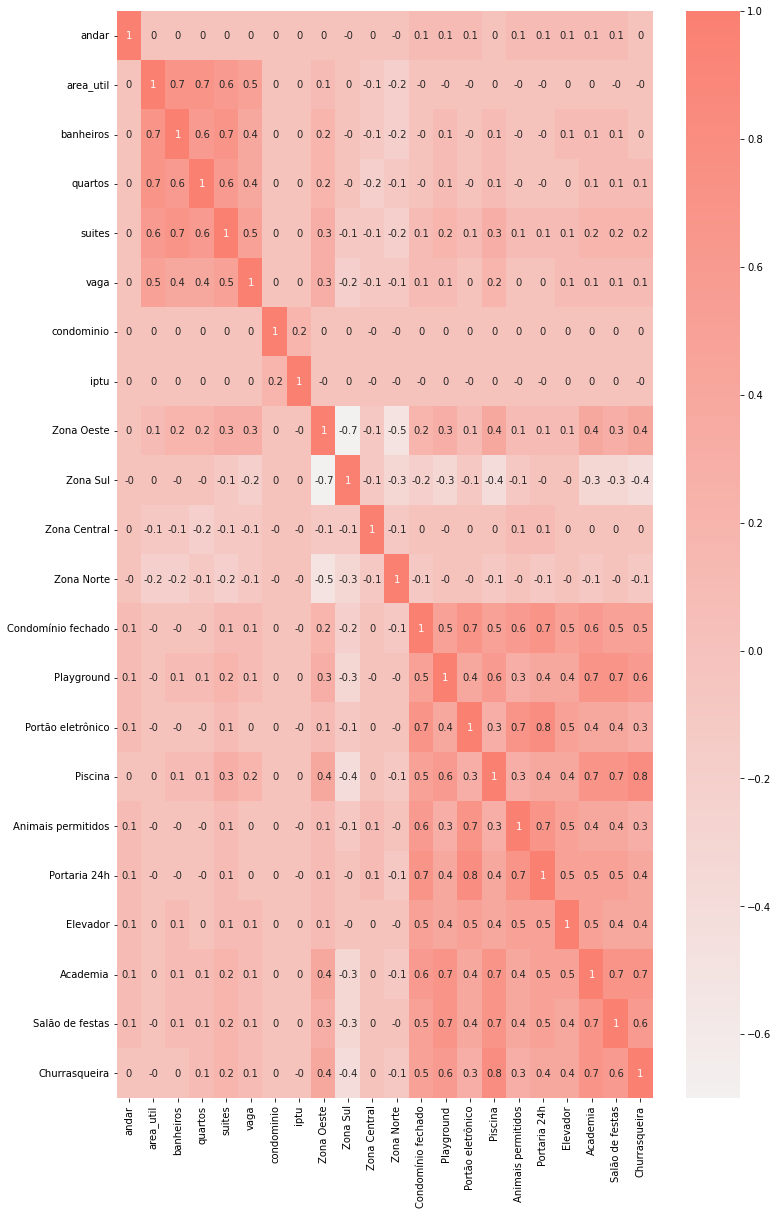

In [72]:
plt.figure(figsize=(12,20))
paleta = sns.color_palette('light:salmon', as_cmap=True)
sns.heatmap(df_correlacao.round(1), annot=True, cmap=paleta)

# vemos a multicolinearidade
# se a correlacao de dois fatores forem muito alta é importe retirar um deles na análise

## **Criação do modelo Regressão Linear e métricas**

In [73]:
# ajuste e previsao

from pyspark.ml.regression import LinearRegression

In [74]:
treino, teste = dados_prep.randomSplit([0.7, 0.3], seed=101) #separando 30% para teste

In [75]:
treino.count()

46426

In [76]:
teste.count()

19911

In [77]:
lr = LinearRegression()

In [78]:
modelo_lr = lr.fit(treino)

In [79]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [80]:
previsoes_lr_treino.show() # é preciso obter métricas para avaliar as previsões

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|1824000.0|1570247.6445533838|
|(22,[0,1,2,3,4,5,...|1100000.0| 2769467.426923275|
|(22,[0,1,2,3,4,5,...| 950000.0|1315209.7263781428|
|(22,[0,1,2,3,4,5,...| 790000.0| 494092.6859032074|
|(22,[0,1,2,3,4,5,...|1050000.0|1651861.6479266752|
|(22,[0,1,2,3,4,5,...|3980000.0|3578079.0160951354|
|(22,[0,1,2,3,4,5,...|4660625.0|3177610.1343246074|
|(22,[0,1,2,3,4,5,...| 925000.0|1312786.0625299942|
|(22,[0,1,2,3,4,5,...|2293400.0|1655177.6319315685|
|(22,[0,1,2,3,4,5,...|5784000.0|  2925410.24068971|
|(22,[0,1,2,3,4,5,...|2200000.0|1603849.9617833653|
|(22,[0,1,2,3,4,5,...| 539000.0| 615356.7869320726|
|(22,[0,1,2,3,4,5,...| 495000.0|  619121.922512847|
|(22,[0,1,2,3,4,5,...| 900000.0|  547121.720783703|
|(22,[0,1,2,3,4,5,...|1595000.0|1521294.5548586668|
|(22,[0,1,2,3,4,6,...|1190000.0|1160317.5694356402|
|(22,[0,1,2,

In [81]:
resumo_treino = modelo_lr.summary

In [82]:
resumo_treino.r2 

0.6780509260292227

In [83]:
resumo_treino.rootMeanSquaredError 

828209.736674596

In [84]:
resumo_teste = modelo_lr.evaluate(teste)

In [85]:
resumo_teste.r2

0.6335103100848398

In [86]:
resumo_teste.rootMeanSquaredError

904073.3133319446

## **Tabela de resumo da Regressão Linear (R² e RMSE)**

In [87]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % resumo_treino.r2)
print("RMSE: %f" % resumo_treino.rootMeanSquaredError)
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % resumo_teste.r2)
print("RMSE: %f" % resumo_teste.rootMeanSquaredError)

Linear Regression
Dados de Treino
R²: 0.678051
RMSE: 828209.736675

Dados de Teste
R²: 0.633510
RMSE: 904073.313332


## **Criação do modelo Decision Tree e métricas**

In [88]:
# ajuste e previsão

from pyspark.ml.regression import DecisionTreeRegressor

In [89]:
dtr = DecisionTreeRegressor(seed=101, maxDepth=7)

In [90]:
modelo_dtr = dtr.fit(treino)

In [91]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [92]:
previsoes_dtr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|1824000.0| 1809259.337535014|
|(22,[0,1,2,3,4,5,...|1100000.0|1388841.1782786886|
|(22,[0,1,2,3,4,5,...| 950000.0| 1809259.337535014|
|(22,[0,1,2,3,4,5,...| 790000.0|  696755.006993007|
|(22,[0,1,2,3,4,5,...|1050000.0|1004920.0232758621|
|(22,[0,1,2,3,4,5,...|3980000.0|         3871533.5|
|(22,[0,1,2,3,4,5,...|4660625.0|3870372.2822580645|
|(22,[0,1,2,3,4,5,...| 925000.0|1256709.0893947806|
|(22,[0,1,2,3,4,5,...|2293400.0|1577468.6032258065|
|(22,[0,1,2,3,4,5,...|5784000.0| 3666027.076923077|
|(22,[0,1,2,3,4,5,...|2200000.0| 1159965.857142857|
|(22,[0,1,2,3,4,5,...| 539000.0|376318.70344827586|
|(22,[0,1,2,3,4,5,...| 495000.0| 671215.9751368257|
|(22,[0,1,2,3,4,5,...| 900000.0| 671215.9751368257|
|(22,[0,1,2,3,4,5,...|1595000.0| 1809259.337535014|
|(22,[0,1,2,3,4,6,...|1190000.0| 856399.6977535739|
|(22,[0,1,2,

In [93]:
from pyspark.ml.evaluation import RegressionEvaluator

In [94]:
evaluator = RegressionEvaluator()

print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))

0.7976370502070388
656617.1812852314


In [95]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [96]:
previsoes_dtr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 845000.0|1004920.0232758621|
|(22,[0,1,2,3,4,5,...|1450000.0|1111202.6233463036|
|(22,[0,1,2,3,4,5,...| 335000.0| 671215.9751368257|
|(22,[0,1,2,3,4,5,...| 489900.0| 671215.9751368257|
|(22,[0,1,2,3,4,5,...|1922000.0|1111202.6233463036|
|(22,[0,1,2,3,4,6,...| 735000.0| 856399.6977535739|
|(22,[0,1,2,3,4,6,...|1450000.0| 856399.6977535739|
|(22,[0,1,2,3,4,6,...| 535000.0| 856399.6977535739|
|(22,[0,1,2,3,6,7,...| 600000.0| 552733.9381139489|
|(22,[0,1,2,3,6,7,...| 290000.0|392630.60425531917|
|(22,[0,1,2,3,6,7,...| 350000.0|392630.60425531917|
|(22,[0,1,2,3,6,7,...| 260000.0|364041.06076975015|
|(22,[0,1,2,3,11],...| 220000.0|250498.17036580353|
|(22,[1,2,3,4,5,6,...| 629150.0| 671215.9751368257|
|(22,[1,2,3,4,5,6,...| 440000.0|1004920.0232758621|
|(22,[1,2,3,4,5,6,...| 847000.0|1004920.0232758621|
|(22,[1,2,3,

# **Tabela de resumo do modelo Decision Tree (R² e RMSE)**

In [97]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.797637
RMSE: 656617.181285

Dados de Teste
R²: 0.764727
RMSE: 724366.921366


# **Criação do modelo de Randon Forest e métricas**

In [98]:
from pyspark.ml.regression import RandomForestRegressor

In [99]:
rfr = RandomForestRegressor(seed=101, maxDepth=7, numTrees=10)

In [100]:
modelo_rfr = rfr.fit(treino)

In [101]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [102]:
previsoes_rfr_treino.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...|1824000.0|1537930.2444422257|
|(22,[0,1,2,3,4,5,...|1100000.0|1720279.7300992007|
|(22,[0,1,2,3,4,5,...| 950000.0|1537930.2444422257|
|(22,[0,1,2,3,4,5,...| 790000.0| 714038.2124507872|
|(22,[0,1,2,3,4,5,...|1050000.0|1429528.0919044914|
|(22,[0,1,2,3,4,5,...|3980000.0|3502892.3160656593|
|(22,[0,1,2,3,4,5,...|4660625.0| 3392059.901119873|
|(22,[0,1,2,3,4,5,...| 925000.0|  950596.924297185|
|(22,[0,1,2,3,4,5,...|2293400.0|1526524.1160639662|
|(22,[0,1,2,3,4,5,...|5784000.0|2645893.8104096116|
|(22,[0,1,2,3,4,5,...|2200000.0|1988928.3888766703|
|(22,[0,1,2,3,4,5,...| 539000.0| 397935.5353101321|
|(22,[0,1,2,3,4,5,...| 495000.0|  625498.192895736|
|(22,[0,1,2,3,4,5,...| 900000.0|  625498.192895736|
|(22,[0,1,2,3,4,5,...|1595000.0|1537930.2444422257|
|(22,[0,1,2,3,4,6,...|1190000.0| 880425.7098710292|
|(22,[0,1,2,

In [103]:
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print(evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))

0.8074114538278794
640563.1764911914


In [104]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [105]:
previsoes_rfr_teste.show()

+--------------------+---------+------------------+
|            features|    label|        prediction|
+--------------------+---------+------------------+
|(22,[0,1,2,3,4,5,...| 845000.0| 805679.4079231288|
|(22,[0,1,2,3,4,5,...|1450000.0|1438589.0114774678|
|(22,[0,1,2,3,4,5,...| 335000.0| 601377.5317903373|
|(22,[0,1,2,3,4,5,...| 489900.0|  572176.516285731|
|(22,[0,1,2,3,4,5,...|1922000.0|1440735.2839453565|
|(22,[0,1,2,3,4,6,...| 735000.0|1173441.0599398594|
|(22,[0,1,2,3,4,6,...|1450000.0| 880425.7098710292|
|(22,[0,1,2,3,4,6,...| 535000.0| 832383.8196310801|
|(22,[0,1,2,3,6,7,...| 600000.0| 615273.2629794254|
|(22,[0,1,2,3,6,7,...| 290000.0| 516948.4544244458|
|(22,[0,1,2,3,6,7,...| 350000.0| 516948.4544244458|
|(22,[0,1,2,3,6,7,...| 260000.0| 584619.2518573184|
|(22,[0,1,2,3,11],...| 220000.0| 282963.5403830693|
|(22,[1,2,3,4,5,6,...| 629150.0| 655468.5367153179|
|(22,[1,2,3,4,5,6,...| 440000.0|  789726.410188355|
|(22,[1,2,3,4,5,6,...| 847000.0|1056286.4866662733|
|(22,[1,2,3,

# **Tabela de resumo Randon Forest (R² e RMSE)**

In [107]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.807411
RMSE: 640563.176491

Dados de Teste
R²: 0.785179
RMSE: 692168.161403


# **Árvore de decisão com Cross Validation**

In [114]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator

In [109]:
dtr = DecisionTreeRegressor()

In [110]:
grid = ParamGridBuilder() \
    .addGrid(dtr.maxDepth, [2, 5, 10]) \
    .addGrid(dtr.maxBins, [10, 32, 45]) \
    .build()

In [111]:
evaluator = RegressionEvaluator()

In [112]:
dtr_cv = CrossValidator(
    estimator=dtr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed = 101
    )

In [115]:
modelo_dtr_cv = dtr_cv.fit(treino)

Py4JJavaError: ignored

In [ ]:
previsoes_dtr_cv_teste = modelo_dtr_cv.transform(teste)

In [114]:
print('Árvore de Decisão')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_cv_teste, {evaluator.metricName: "rmse"}))

Árvore de Decisão
Sem Cross Validation
R²: 0.764727
RMSE: 724366.921366

Com Cross Validation
R²: 0.795303
RMSE: 675660.469896


# **Random Forest com Cross Validation**

In [115]:
from pyspark.ml.regression import RandomForestRegressor

In [116]:
rfr = RandomForestRegressor()

In [117]:
grid = ParamGridBuilder() \
    .addGrid(rfr.numTrees, [10, 20, 30]) \
    .addGrid(rfr.maxDepth, [5, 10]) \
    .addGrid(rfr.maxBins, [10, 32, 45]) \
    .build()

In [118]:
evaluator = RegressionEvaluator()

In [119]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3
)

In [125]:
modelo_rfr_cv = rfr_cv.fit(treino)

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:34879)
Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: ignored

In [126]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

NameError: ignored

In [121]:
print('Random Forest')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:45647)
Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 977, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/content/spark-3.1.2-bin-hadoop2.7/python/lib/py4j-0.10.9-src.zip/py4j/java_gateway.py", line 1115, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Random Forest
Sem Cross Validation


Py4JNetworkError: ignored

# **Fazendo previsões**

In [ ]:
x

In [ ]:
novo_imovel = [{
 'andar': 1,
 'label': 0,
 'area_util': 400,
 'banheiros': 25,
 'quartos': 5,
 'suites': 2,
 'vaga': 2,
 'condominio': 1,
 'iptu': 0,
 'Zona Oeste': 0,
 'Zona Sul': 0,
 'Zona Central': 0,
 'Zona Norte': 1,
 'Condomínio fechado': 0,
 'Playground': 1,
 'Portão eletrônico': 1,
 'Piscina': 1,
 'Animais permitidos': 1,
 'Portaria 24h': 1,
 'Elevador': 1,
 'Academia': 1,
 'Salão de festas': 1,
 'Churrasqueira': 1}]

In [ ]:
meu_imovel = spark.createDataFrame(novo_imovel)

In [ ]:
meu_imovel.show()

In [ ]:
assembler = VectorAssembler(inputCols = x, outputCol = 'features')

In [ ]:
meu_lar_vetorizado = assembler.transform(meu_imovel).select('features', 'label')

In [ ]:
meu_lar_vetorizado.show()

In [ ]:
modelo_rfr_cv.transform(meu_lar_vetorizado).show()